# Underage Labor Detector 

In [19]:
import requests
import torch
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import os
import matplotlib.pyplot as plt
import cv2

## Instance Segmentation

In [2]:
# load Mask2Former fine-tuned on COCO instance segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
SegmentationModel = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-instance")

# GPU acceleration if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SegmentationModel.to(device)

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                     

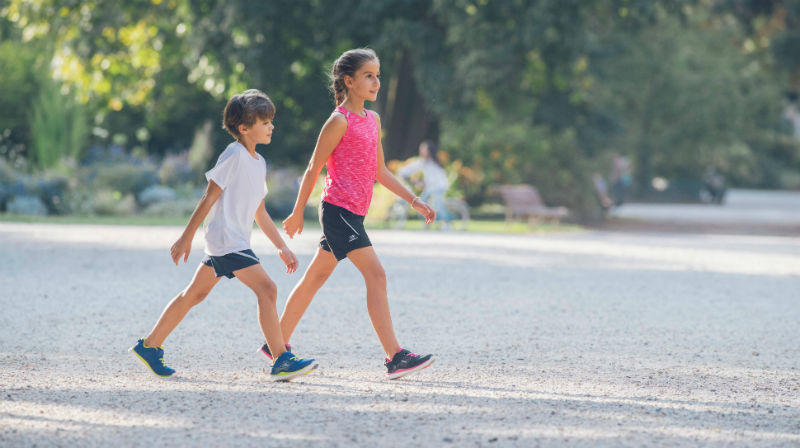

In [53]:
# load an image
#url = "https://s.marketwatch.com/public/resources/images/MW-FY569_child__ZG_20171117100240.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('inputs/test2.jpeg')
image

In [54]:
inputs = processor(images=image, return_tensors="pt")
# forward pass
with torch.no_grad():
    outputs = SegmentationModel(**inputs.to(device))

In [55]:
results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
results

{'segmentation': tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 'segments_info': [{'id': 0,
   'label_id': 13,
   'was_fused': False,
   'score': 0.946542},
  {'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.937693},
  {'id': 2, 'label_id': 0, 'was_fused': False, 'score': 0.890477},
  {'id': 3, 'label_id': 0, 'was_fused': False, 'score': 0.949597}]}

In [56]:
predicted_panoptic_seg = results['segmentation'].cpu().numpy()
predicted_panoptic_seg

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [57]:
results['segments_info']

[{'id': 0, 'label_id': 13, 'was_fused': False, 'score': 0.946542},
 {'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.937693},
 {'id': 2, 'label_id': 0, 'was_fused': False, 'score': 0.890477},
 {'id': 3, 'label_id': 0, 'was_fused': False, 'score': 0.949597}]

Visualizing mask for: 13


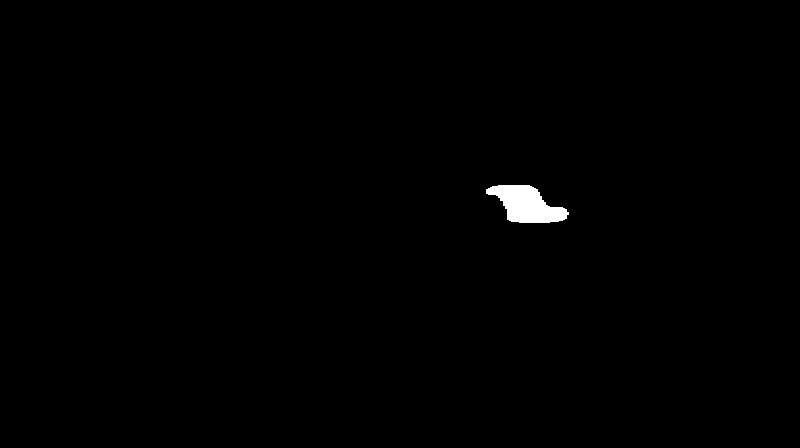

In [58]:
def get_mask(segment_idx):
    segment = results['segments_info'][segment_idx]

    # print("Visualizing mask for:", id2label[segment['label_id']])
    print("Visualizing mask for:", segment['label_id'])
    mask = (predicted_panoptic_seg == segment['id'])

    visual_mask = (mask * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

get_mask(0)

Visualizing mask for: 0
Visualizing mask for: 0


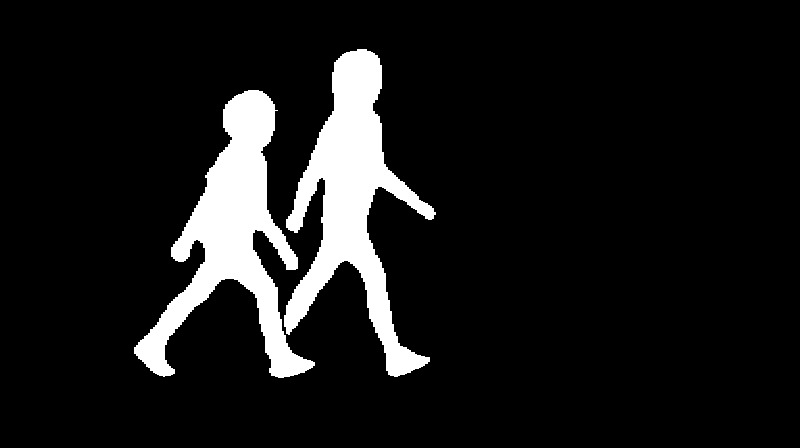

In [59]:
combinedids=[]

for segment in results['segments_info']:
    if(segment["score"] > 0.9 and segment["label_id"] == 0):
        combinedids.append(segment["id"])
        print("Visualizing mask for:", segment['label_id'])

mask = np.isin(predicted_panoptic_seg,combinedids)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Classification

In [60]:
# Load Model

# Define the model architecture (it should be the same architecture as the one you trained)
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Load the weights
model.load_state_dict(torch.load('pretrained/greyModel.pth'))

# Move the model to the desired device (e.g., GPU)
model = model.to(device)

In [61]:
# preprocessing transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
])

In [82]:
# getting the mask and cropped to just the object of interest
def get_mask_from_segment(segment):
    mask = (predicted_panoptic_seg == segment['id'])
    visual_mask = (mask * 255).astype(np.uint8)

    # Find the bounding box of the white region
    rows = np.any(visual_mask, axis=1)
    cols = np.any(visual_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    # Adjust the bounding box coordinates to add padding
    padding = 20
    #rmin = max(rmin - padding, 0)
    cmin = max(cmin - padding, 0)
    #rmax = min(rmax + padding, visual_mask.shape[0] - 1)
    cmax = min(cmax + padding, visual_mask.shape[1] - 1)

    # Crop the mask using the bounding box
    cropped_mask = visual_mask[rmin:rmax+1, cmin:cmax+1]
    
    return Image.fromarray(cropped_mask)


# fabricate a GEI from the segmented mask
def fabricate_gei(image, num_transformations=10):
    single_frame = np.array(image)
    height, width = single_frame.shape
    transformed_frames = [single_frame]
    
    for _ in range(num_transformations):
        # Apply a random translation
        M = np.float32([[1, 0, np.random.randint(-5, 5)], [0, 1, np.random.randint(-5, 5)]])
        translated = cv2.warpAffine(single_frame, M, (width, height))
        
        # Apply a random rotation
        M = cv2.getRotationMatrix2D((width/2, height/2), np.random.randint(-5, 5), 1)
        rotated = cv2.warpAffine(single_frame, M, (width, height))
        
        transformed_frames.append(translated)
        transformed_frames.append(rotated)
    
    # Compute the average of the transformed frames to generate the synthetic GEI
    gei = np.mean(transformed_frames, axis=0)

    # Normalize the GEI to have values between 0 and 255
    gei_normalized = ((gei - gei.min()) * (1/(gei.max() - gei.min()) * 255)).astype('uint8')
    
    return gei_normalized


Probability for Instance  1 :  0.9855109453201294
Probability for Instance  3 :  0.9284376502037048
No Child Detected


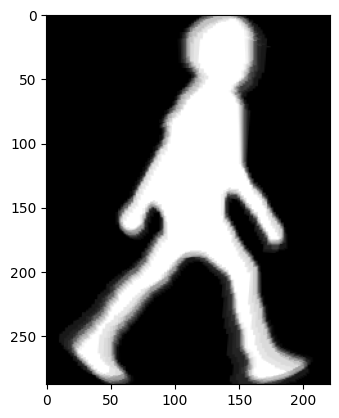

In [83]:
# Loop through instances
with torch.no_grad():
    for segment in results['segments_info']:

        # check if it's a person with a high confidence
        if(segment["score"] > 0.9 and segment["label_id"] == 0):
            
            # get the instance mask 
            image = get_mask_from_segment(segment)
            image = fabricate_gei(image)
            plt.imshow(image, cmap='gray')
            # Preprocess the image
            input_tensor = transform(Image.fromarray(image.astype(np.uint8)))
            input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

            # Move the input batch to the device (GPU or CPU) and run inference
            input_batch = input_batch.to(device)
            
            output = model(input_batch)
            prob = torch.sigmoid(output).item()  # Get the probability

            print("Probability for Instance ", segment['id'], ": ", prob)
            if prob < 0.5:
                predicted_class = "Child"

                # Display the instance of the child
                plt.imshow(image, cmap='gray')
                plt.title(f"Predicted: {predicted_class}")
                plt.axis('off')
                plt.show()

                break # stop looking through the frame after finding a child
    
    else:
        print("No Child Detected") # looped through all segments and didnt predict the child class